<a href="https://colab.research.google.com/github/wendy-guo/floral-garden/blob/main/floral_garden.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Flower dataset classification
one of 5 flowers
daisy, rose, tulip, dandelion, sunflower


In [ ]:
#list all the pip installs
pip install tensorflow-datasets

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

import os
import PIL
import PIL.Image

In [ ]:
flower_names = ["daisy", "tulip", "sunflower", "rose", "dandelion"]

In [ ]:
flower_dataset, dataset_info = tfds.load("tf_flowers", with_info=True, split=['train[:80%]', 'train[80%:]'])
(train_set, test_set) = flower_dataset

print(len(train_set), len(test_set))


2936 734


display trainset subplots

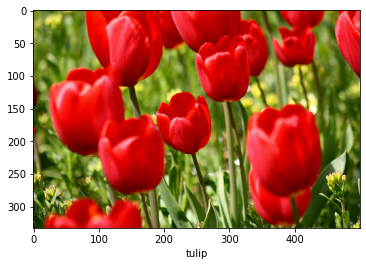

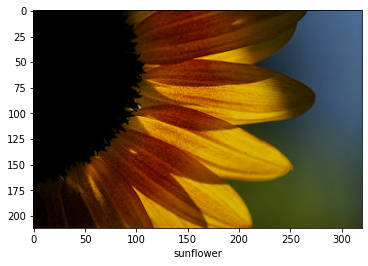

In [ ]:
i = 0
plt.figure()
for item in train_set:
  image = item["image"]
  label = int(item["label"])
  plt.imshow(image)
  plt.xlabel(flower_names[label - 1])
  plt.show()

  i += 1
  if i == 2:
    break

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.fit(train_images, train_labels, epochs=10)